## Assignment 9A:
### This notebook uses Tensorflow 2
#### Integrate GRADCAM :
As proof of integration, test 4 images (remember the image ids or names) from your network and show the visualization




In [3]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 120kB/s 
     |████████████████████████████████| 450kB 32.2MB/s 
     |████████████████████████████████| 3.8MB 25.7MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
# from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import tensorflow as tf
import tensorflow.keras as tfk
import os
import io
import requests
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import random

In [2]:
tf.__version__

'2.0.0'

In [3]:
# Load cifar using the load data function
# The data is in the shape of (Batch_size, num_channel, width, height)
# np.unique returns unique class names

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(num_classes)

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
10


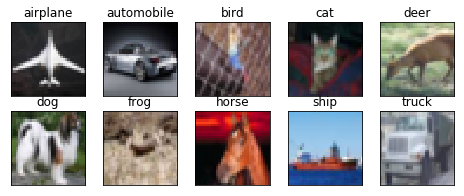

In [4]:
# Visualization of some particular classes from the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5,1 + i, xticks=[], yticks=[])
    # gets the all the position of a particular class
    idx = np.where(train_labels[:]==i)[0]
    # using the idx we can find the corresponding image arrays
    features_idx = train_features[idx,::]
    # selects an img num by random
    img_num = np.random.randint(features_idx.shape[0])
    # gets the img array by img num
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Normalize data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# Convert class labels to binary class labels
train_labels = tfk.utils.to_categorical(train_labels, num_classes)
test_labels = tfk.utils.to_categorical(test_labels, num_classes)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load the saved model 6A

In [7]:
filepath = '/content/drive/My Drive/EVA/Session9/weights-improvement-best.hdf5'
model = tfk.models.load_model(filepath)
model.summary()
# serialize model to JSON
# model_json = model.to_json()
# with open("/content/drive/My Drive/EVA/Session9/model_architecture.json", "w") as json_file:
#     json_file.write(model_json)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256   

In [0]:
# Since tensorflow 2 doesn't let us use K.gradients, Gadientape is being used
# Softmax layer is removed, because gradients were all coming 0 wrt soft max
# source https://github.com/keras-team/keras/issues/5881 --> for softmax solution
# https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras

In [0]:
def gradCam(img_tensors):
  preds = model.predict(img_tensors)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_8")
  
  heatmap_model = tfk.models.Model([model.input], [last_conv_layer.output, model.get_layer("global_average_pooling2d").output])
  with tf.GradientTape() as gtape:
      conv_output, predictions = heatmap_model(img_tensors)
      loss = predictions[:, np.argmax(predictions[0])]
      grads = gtape.gradient(loss, conv_output)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = np.squeeze(heatmap)
  return heatmap

def plotHeatMap(heatmap_full,imgs,img_test_labels):
  imgs = (imgs * 255).round().astype(np.uint8)
  num_images = imgs.shape[0]
  for i in range(num_images):
    heatmap = cv2.resize(heatmap_full[i], (imgs.shape[2], imgs.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(imgs[i], 0.6, heatmap, 0.4, 0)
    fig, axes = plt.subplots(1,2, figsize=(10, 10))
    axes[0].set_title(img_test_labels[i])
    axes[0].imshow(imgs[i])
    axes[1].set_title(img_test_labels[i])
    axes[1].imshow(superimposed_img)

test images ids  [5603 5797 3810 8703 8200]
['dog', 'dog', 'cat', 'deer', 'cat']


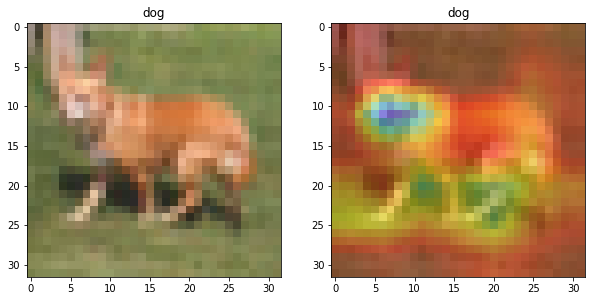

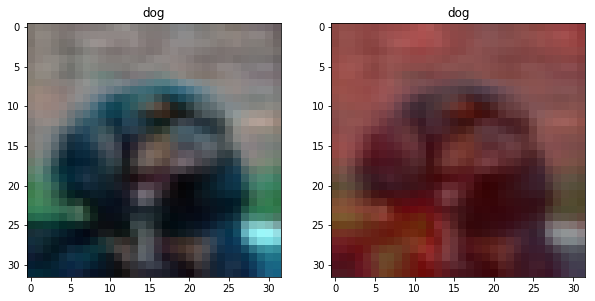

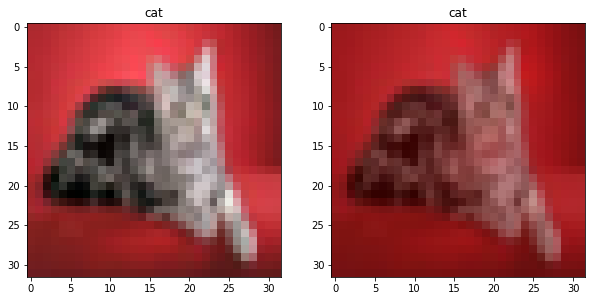

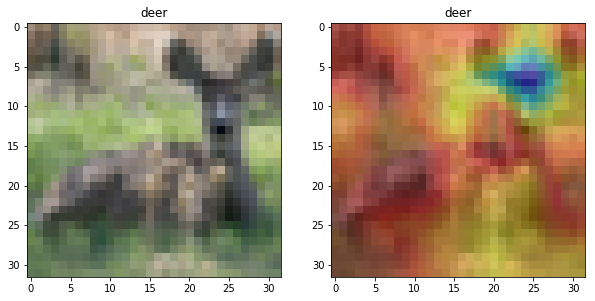

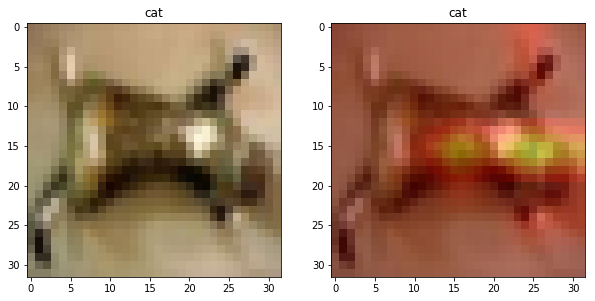

In [10]:
np.random.seed(314159)
imgs_test_ids = np.random.choice(len(test_labels), 5,replace=False)
imgs_test = np.array([test_features[x] for x in imgs_test_ids])
img_test_labels = np.array([np.argmax(test_labels[x]) for x in imgs_test_ids])
img_test_labels = [class_names[value] for index,value in enumerate(img_test_labels)]
print('test images ids ',imgs_test_ids)
print(img_test_labels)
heatmap_full = gradCam(imgs_test)
plotHeatMap(heatmap_full,imgs_test,img_test_labels)

### Cutout implimentation


In [0]:
# code is used from https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# test a image with cutout
eraser = get_random_eraser()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


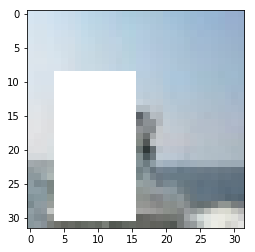

In [14]:
img = eraser(train_features[100])
plt.imshow(img)

In [0]:
# This function plots 2 graph --> model acc(train,val) vs epoch/ model loss(train,val) vs epoch

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Returns accuracy on test data

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# load 6a model without the weight to train it again with cutout
with open("/content/drive/My Drive/EVA/Session9/model_architecture.json", "r") as f:
  loaded_model_json = f.read()
model = tfk.models.model_from_json(loaded_model_json)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256   

In [0]:
import os
# Define the callbacks --> checkpoint and learning rate schedular
base_dir = '/content/drive/My Drive/EVA/Session9'

def scheduler(epoch, lr):
    return round(0.003 * 1 / (1 + 0.319 * epoch), 10)

if not (os.path.exists(os.path.join(base_dir, 'weights'))):
    os.mkdir(os.path.join(base_dir, 'weights'))

filepath = os.path.join('/content/drive/My Drive/EVA/Session9/weights',
                        'weights-improvement-cutout-best.hdf5')

checkpoint = tfk.callbacks.ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

In [0]:
datagen = tfk.preprocessing.image.ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0.1, v_h=0.3))
# Compile the model
model.compile(optimizer = tf.optimizers.Adam(lr=0.003), loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.003.
Epoch 1/100
390/391 [============================>.] - ETA: 0s - loss: 1.4611 - accuracy: 0.4637
Epoch 00001: val_accuracy improved from -inf to 0.36570, saving model to /content/drive/My Drive/EVA/Session9/weights/weights-improvement-cutout-best.hdf5
391/391 [==============================] - 80s 204ms/step - loss: 1.4607 - accuracy: 0.4638 - val_loss: 1.8881 - val_accuracy: 0.3657

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0022744503.
Epoch 2/100
390/391 [============================>.] - ETA: 0s - loss: 1.0813 - accuracy: 0.6095
Epoch 00002: val_accuracy improved from 0.36570 to 0.48440, saving model to /content/drive/My Drive/EVA/Session9/weights/weights-improvement-cutout-best.hdf5
391/391 [==============================] - 83s 213ms/step - loss: 1.0813 - accuracy: 0.6095 - val_loss: 1.5181 - val_accuracy: 0.4844

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0018315018.
Epoc

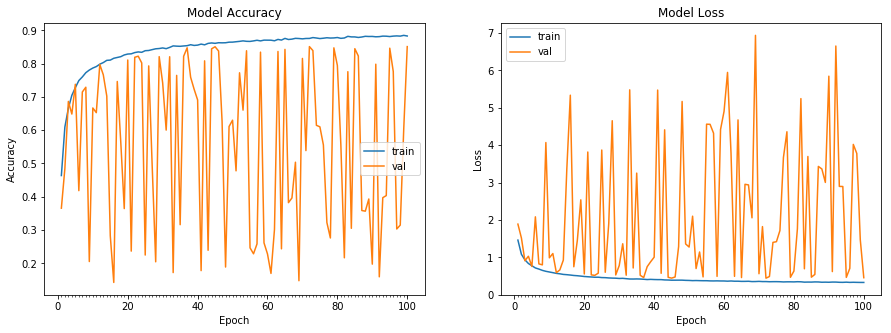

Accuracy on test data is: 85.11


In [0]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128), epochs = 100,
                                 validation_data = (test_features, test_labels), verbose=1,
                                callbacks=[tfk.callbacks.LearningRateScheduler(scheduler, verbose=1), checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

test images ids  [5603 5797 3810 8703 8200]
['dog', 'dog', 'cat', 'deer', 'cat']


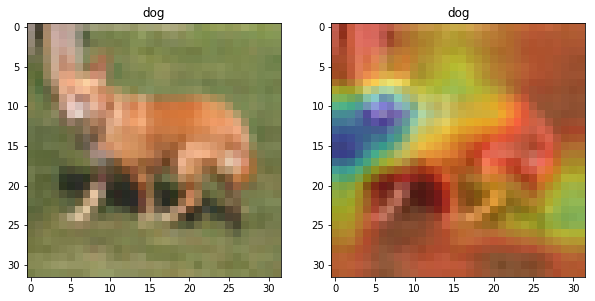

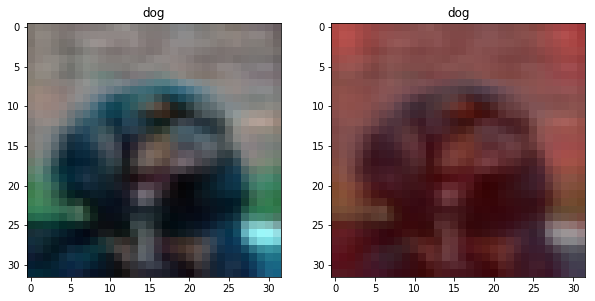

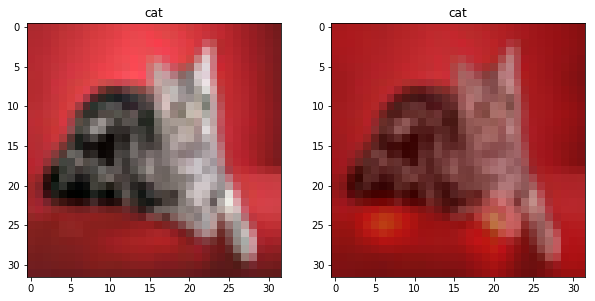

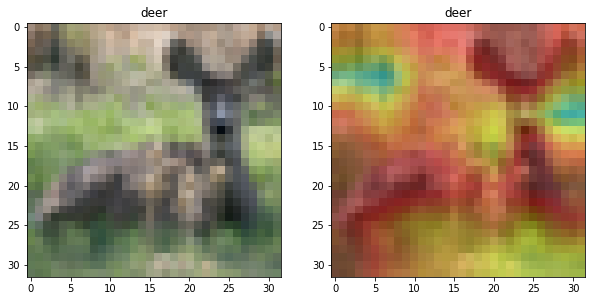

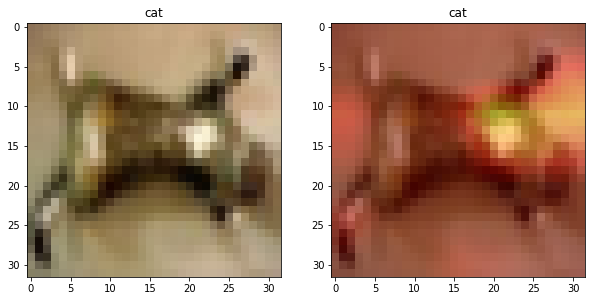

In [17]:
# results with cutout
np.random.seed(314159)
imgs_test_ids = np.random.choice(len(test_labels), 5,replace=False)
imgs_test = np.array([test_features[x] for x in imgs_test_ids])
img_test_labels = np.array([np.argmax(test_labels[x]) for x in imgs_test_ids])
img_test_labels = [class_names[value] for index,value in enumerate(img_test_labels)]
print('test images ids ',imgs_test_ids)
print(img_test_labels)
heatmap_full = gradCam(imgs_test)
plotHeatMap(heatmap_full,imgs_test,img_test_labels)